# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [2]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import pylab as pl
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

##File of fancy plot style. To use des.mplstyle file you must have an LaTeX distribution in your system
plt.style.use(machine_path+'/Mestrado/cenarios/mandyoc/scripts_gera_inputs_imgs/new_outputs/des.mplstyle')

In [2]:
def read_params(fpath):
    '''
    Read param.txt and returns Nx, Nz, Lx, Lz of the scenario givem by fpath
    
    Parameters
    ----------
    
    fpath: str
        Path to the param.txt file
    '''
    
    with open(fpath+"param.txt","r") as f:
        line = f.readline()
        line = line.split() #split by space a string to a list of strings
        Nx = int(line[-1])
        
        line = f.readline()
        line = line.split()
        Nz = int(line[-1])

        line = f.readline()
        line = line.split()
        Lx = float(line[-1])

        line = f.readline()
        line = line.split()
        Lz = float(line[-1])

    return Nx, Nz, Lx, Lz


def read_data(prop, step, fpath):
    '''
    Read and reshape read data according to parameters to return a (Nx, Nz) array.
    
    Parameters
    ----------
    
    prop: str
        Property of the mandyoc outputs: temperature, density, strain, strain_rate, viscosity, heat or pressure.
        
    step: str
        Time step of numerical scenario.
        
    fpath: str
        Path to the param.txt file.
    '''
    
    Nx, Nz, Lx, Lz = read_params(fpath)
    file_name = prop+"_"+str(step)+".txt"

    A = np.loadtxt(fpath+file_name, unpack=True, comments="P", skiprows=2)
    TT = A*1.0
    TT[np.abs(TT)<1.0E-200]=0
    TT = np.reshape(TT, (Nx,Nz), order='F')
    TTT = TT[:,:]

    return TTT
        
def read_density(fpath, step, Nx, Nz):
    '''
    Read and reshape readed data according to parameters to return a (Nz, Nx) array.
    
    Parameters
    ----------
    fpath: str
        Path to the param.txt file.
        
    step: str
        Time step of numerical scenario.
        
    Nx: int
        Number of points in x direction.
        
    Nz: int
        Number of points in z direction.
    '''

    Rho = np.loadtxt(fpath+"density_"+str(step)+".txt",skiprows=2, unpack=True, comments="P")
    Rho = np.reshape(Rho, (Nz, Nx))

    return Rho

def read_temperature(fpath, step, Nx, Nz):
    '''
    Read temperature data from temperature_step.txt  and reshape to a (Nz, Nx) array
    
    Parameters
    ----------
    fpath: str
        Path to the param.txt file.
        
    step: str
        Time step of numerical scenario.
        
    Nx: int
        Number of points in x direction.
        
    Nz: int
        Number of points in z direction.
    '''

    Temper = np.loadtxt(fpath+"temperature_"+str(step)+".txt",skiprows=2, unpack=True, comments="P")
    Temper = np.reshape(Temper, (Nz, Nx))

    return Temper

def extract_interface(z, Z, Nx, Rhoi, rho):
    '''
    Extract interface from Rhoi according to a given density (rho)

    Parameters
    ----------
    z: array_like
        Array representing z direction.

    Z: array_like
        Array representing z direction resampled with higher resolution.

    Nx: int
        Number of points in x direction.

    Rhoi: array_like (Nz, Nx)
        Density field from mandyoc

    rho: int
        Value of density to be searched in Rhoi field
    '''

    topo_aux = []

    for j in np.arange(Nx):
        topoi = interp1d(z, Rhoi[:,j]) #return a "function" of interpolation to apply in other array
        idx = (np.abs(topoi(Z)-rho)).argmin()
        topo = Z[idx]
        topo_aux = np.append(topo_aux, topo)

    return topo_aux

def find_nearest(array, value):
    '''Return the index in array nearest to a given value.
    
    Parameters
    ----------
    
    array: array_like
        1D array used to find the index
        
    value: float
        Value to be seached
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def read_times_steps(fpath):
    '''List and sort the time*.txt files
       
       Parameters
       ----------
       fapth: str
           Path to scenario directory.
    '''
    
    steps = []
    times = []
    
    ts = sorted(glob.glob(fpath+"time_*.txt"), key=os.path.getmtime)
    total_curves = len(ts)
    step_initial = int(ts[0].split('/')[-1][5:-4])
    step_final = int(ts[-1].split('/')[-1][5:-4])
    dstep = int(ts[1].split('/')[-1][5:-4]) - int(ts[0].split('/')[-1][5:-4])

    for step in range(step_initial, step_final+1, dstep):
        step = int(step)
        time_fname = "time_" + str(step) + ".txt"
        time = np.loadtxt(fpath+time_fname, usecols=2, max_rows=1)
        time = round(time/1.0E6, 2)
        steps = np.append(steps, int(step))
        times = np.append(times, time)
    steps = np.asarray(steps)
    steps = steps.astype('int')
    return times, steps

def trim_axs(axs, N):
    '''Little helper to index the axs as 1D list
       
       Parameters
       ----------
       axs: `~matplotlib.axes.Axes` list of Axes
           
       N: int
           Total number of subplots.
    '''
    
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_single_step(fpath, ax, prop, instants, step, xlims, ylims):
    '''
    Plot data from mandyoc according to a given property.

    Parameters
    ----------
    fapth: str
           Path to scenario directory.
    
    ax: 
        `~matplotlib.axes.Axes`

    prop: str
        Property from mandyoc.     

    step: int
        Step of Mandyoc output files .

    xlims: list
        List with the limits of x axis
        
    ylims: list
        List with the limits of y axis
    '''
    
    #label of colorbars
#     print(prop)
    props_label = {'density':              r'$\mathrm{[kg/m^3]}$',
                   'heat':                 'log(W/kg)',
                   'lithology':            r'log$(\epsilon_{II})$',
                   'pressure':             'P [GPa]',
                   'strain':               r'Accumulated strain [$\varepsilon$]',
                   'strain_rate':          r'log($\dot{\varepsilon}$)',
                   'temperature':          r'$^{\circ}\mathrm{[C]}$',
                   'temperature_anomaly':  r'Temperature anomaly $^{\circ}\mathrm{[C]}$',
                   'topography':           'Topography [km]',
                   'viscosity':            'log(Pa.s)',
                   'vs_anomaly':           r'dVs/Vs [\%]'
                   }
    
    props_cmap = {'density': 'viridis',
                  'heat': 'inferno',
                  'lithology': 'viridis',
                  'pressure': 'viridis',
                  'strain': 'viridis', #Default. Comment this line and uncomment one of the options bellow
#                   'strain': 'cividis',
#                   'strain': 'Greys',
#                   'strain': 'inferno',
#                   'strain': 'magma',
                  'strain_rate': 'viridis',
                  'temperature': 'viridis',
                  'temperature_anomaly': 'RdBu_r',
                  'topography': '',
                  'viscosity': 'viridis'
                   }

    #limits of colorbars
    vals_minmax = {'density':             [0.0, 3378.],
                   'heat':                [np.log10(1.0E-13), np.log10(1.0E-9)],
                   'lithology':           [None, None],
                   'pressure':            [-1.0E-3, 1.0],
                   'strain':              [None, None],
                   'strain_rate':         [np.log10(1.0E-19), np.log10(1.0E-12)],
                   'temperature':         [0, 1600],
                   'temperature_anomaly': [-150, 150],
                   'topography':          [-6, 6],
                   # 'viscosity':           [np.log10(1.0E16), np.log10(1.0E25)],
                   # 'viscosity':           [np.log10(1.0E22), np.log10(1.0E25)],
                   'viscosity':           [np.log10(1.0E18), np.log10(1.0E25)]
                  }

    Nx, Nz, Lx, Lz = read_params(fpath)

    ##Creating a grid to plot
    xi = np.linspace(0, Lx/1000, Nx)
    zi = np.linspace(-Lz/1000+40, 0+40, Nz) #km, +40 to compensate the air layer above sea level
    xx, zz = np.meshgrid(xi, zi)

#             idx = np.where(tab['Steps']==stp[0])[0][0]

    #Removing the mean uplift between of left side
    #condx = (xi >= 100) & (xi <= 600)
    # z_mean = np.mean(topography[condx])
    z_mean = 40.0 #np.mean(topo[condx])
    
    fname = fpath + 'sp_surface_global_' + str(step) + '.txt'
    topo = np.loadtxt(fname, unpack=True, skiprows=2, comments='P')/1.0E3
    topo = topo + 40
    condx = (xi >= 100) & (xi <= 400)
    mean = np.mean(topo[condx])
    topoi = topo - np.abs(mean)
    

    val_minmax = vals_minmax[prop]
    
    if(prop == 'lithology'):
        data = read_data('strain', step, fpath)
        
    elif(prop == 'temperature_anomaly'):
        data = read_data('temperature', step, fpath)
        
    elif(prop == 'topography'):
        topo_from_density = True
        
        if(topo_from_density == True):
            Rhoi = read_density(fpath, step, Nx, Nz)
            interfaces=[2900, 3365]
            ##Extract layer topography
            z = np.linspace(Lz/1000.0, 0, Nz)
            Z = np.linspace(Lz/1000.0, 0, 8001) #zi
            x = np.linspace(Lx/1000.0, 0, Nx)
            
            condx = (xi >= 100) & (xi <= 600)
#             Rho0 = read_density(fpath, instants[0], Nx, Nz)
#             topo_interface0 = extract_interface(z, Z, Nx, Rho0, 200.)
#             z_mean = np.mean(topo_interface0[condx])

            topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
            z_mean = np.mean(topo_interface[condx])
#             z_mean = 40.0 #np.mean(topo[condx]) 

            topo_interface -= np.abs(z_mean)
            topo_interface = -1.0*topo_interface

            data = topo_interface
            
        else:
            data = topoi
        
    else:
        data = read_data(prop, step, fpath)
    
    data[data==0] = 1.0E-28 #avoid log(0)
    
    if(prop == 'lithology' or prop == "strain" or prop == "strain_rate" or prop == "viscosity" or prop == "heat"):
        data = np.log10(data)
    
    #PLOT DATA
    clb_fsize = 18 #colorbar fontsize
    
    if(prop != 'topography'): #Plot isotherms
        Temperi = read_temperature(fpath, step, Nx, Nz)
        
        isotherms=[550, 800, 1300]
#         isotherms=[300, 400, 500, 800, 1000, 1300]
        isot_colors = []
        for isotherm in isotherms:
            isot_colors.append('red')
            
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, colors=isot_colors)

        fmt = {}
        for level, isot in zip(cs.levels, isotherms):
            fmt[level] = str(level) + r'$^{\circ}$C'

        ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True, fontsize=12)
    
    if(prop != 'lithology' and prop != 'strain' and prop != 'pressure' and prop != 'temperature_anomaly' and prop != 'topography'): #properties that need a colorbar
        im = ax.imshow(np.transpose(data),
                       cmap = props_cmap[prop], origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = val_minmax[0],
                       vmax = val_minmax[1],
                       aspect = 'auto')
        
        #colorbar
        ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True)
        clb = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.08, pad=0.01, ticks=ticks,
                    format='%.0f')#, label=props_label[prop])
        clb.set_label(props_label[prop], fontsize=clb_fsize)
        
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
#         ax.fill_between(xaux, topoi[condaux], 38.5, color='white', alpha=1.0, zorder=51)
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
    
    elif(prop == 'strain'):
        im = ax.imshow(np.transpose(data),
                       cmap = props_cmap[prop], origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = val_minmax[0],
                       vmax = val_minmax[1],
                       aspect = 'auto')
        
#         ax.contour(xx, zz, Rhoi, 100, levels=interfaces, colors=['black', 'red'])
        
        ticks = np.linspace(np.min(data), np.max(data), 5, endpoint=True)
        clb = fig.colorbar(im,
                           ax=ax,
                           orientation='vertical',
                           fraction=0.08,
                           pad=0.01,
                           ticks=ticks,
                           format='%.1f')#, label=props_label[prop])
        
        clb.set_label(props_label[prop], fontsize=clb_fsize)
        
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
#         ax.fill_between(xaux, topoi[condaux], 38.5, color='white', alpha=1.0, zorder=51)
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
    
    elif(prop == 'pressure'): #GPa 
        im = ax.imshow(np.transpose(data/1.0E9),
                       cmap=props_cmap[prop],
                       origin='lower',
                       extent=(0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = val_minmax[0],
                       vmax = val_minmax[1],
                       aspect = 'auto')
        
        ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True)
        clb = fig.colorbar(im,
                           ax=ax,
                           orientation='vertical',
                           fraction=0.08,
                           pad=0.01,
                           ticks=ticks,
                           format='%.3f')

        clb.set_label(props_label[prop], fontsize=clb_fsize)
        
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
        
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
        
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
        
    elif(prop == 'temperature_anomaly'):
        
        #removing horizontal mean temperature
        A = data  #shape: (Nx, Nz)
        B = np.transpose(A) #shape: (Nz, Nx)
        C = np.mean(B, axis=1) #shape: 151==Nz
        D = (B.T - C) #B.T (Nx,Nz) para conseguir subtrair C
        
        im = ax.imshow(np.transpose(D), 
                       cmap = props_cmap[prop], 
                       origin = 'lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40), 
                       vmin = val_minmax[0], 
                       vmax = val_minmax[1],
                       aspect = 'auto'
                       )


        ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True)
        clb = fig.colorbar(im,
                           ax=ax,
                           orientation='vertical',
                           fraction=0.08,
                           pad=0.01,
                           ticks=ticks,
                           format='%.0f')
        
        clb.set_label(props_label[prop], fontsize=clb_fsize)
        
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
        
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
            
    elif(prop == 'topography'):
        ax.plot(xx[0], data, alpha = 1, linewidth = 2.0, color = "blueviolet")
        
    elif(prop == 'lithology'): #shaded lithology plot
        cr = 255.
        color_uc = (228. / cr, 156. / cr, 124. / cr)
        color_lc = (240. / cr, 209. / cr, 188. / cr)
        color_lit = (155. / cr, 194. / cr, 155. / cr)
        color_ast = (207. / cr, 226. / cr, 205. / cr)
        
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        ax.contourf(xx,
                    zz,
                    Rhoi,
                    levels = [200., 2750, 2900, 3365, 3900],
                    colors = [color_uc, color_lc, color_lit, color_ast])
        
        im=ax.imshow(np.transpose(data),
                     cmap = 'Greys',
                     origin = 'lower',
                     extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40,0 + 40),
                     zorder = 50,
                     alpha = 0.2, vmin=-0.5,
                     vmax = 0.7,
                     aspect = 'auto')
        
        b1 = [0.89, 0.12, 0.08, 0.08]
        bv1 = plt.axes(b1)
        A = np.zeros((100, 10))

        A[:25, :] = 2700
        A[25:50, :] = 2800
        A[50:75, :] = 3300
        A[75:100, :] = 3400

        A = A[::-1, :]

        xA = np.linspace(-0.5, 0.9, 10)
        yA = np.linspace(0, 1.5, 100)

        xxA, yyA = np.meshgrid(xA, yA)
        air_threshold = 200
        plt.contourf(
            xxA,
            yyA,
            A,
            levels=[air_threshold, 2750, 2900, 3365, 3900],
            colors=[color_uc, color_lc, color_lit, color_ast],
        )

        plt.imshow(
            xxA[::-1, :],
            extent=[-0.5, 0.9, 0, 1.5],
            zorder=100,
            alpha=0.2,
            cmap=plt.get_cmap("Greys"),
            vmin=-0.5,
            vmax=0.9,
        )

        bv1.set_yticklabels([])
        plt.xlabel(r"log$(\varepsilon_{II})$", size=14)
        bv1.tick_params(axis='x', which='major', labelsize=12)
        bv1.set_xticks([-0.5, 0, 0.5])
        bv1.set_yticks([])
        bv1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]

    #         ax.fill_between(xaux, topoi[condaux], 38.5, color='white', alpha=1.0, zorder=51)
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)

    
def plot_data(fpath, ax, axs, prop, instants, step, xlims, ylims):
    '''
    Plot data from mandyoc according to a given property.

    Parameters
    ----------
    fapth: str
           Path to scenario directory.
    
    ax: `~matplotlib.axes._subplots.AxesSubplot` Axis subplot.
    
    axs: 
        Numpy array of `~matplotlib.axes.Axes` list of Axes after use of trim_axis function.

    prop: str
        Property from mandyoc.     

    step: int
        Step of Mandyoc output files .

    xlims: list
        List with the limits of x axis
        
    ylims: list
        List with the limits of y axis
    '''
    
    #label of colorbars
#     print(prop)
    props_label = {'density':              r'$\mathrm{[kg/m^3]}$',
                   'heat':                 'log(W/kg)',
                   'lithology':            r'log$(\epsilon_{II})$',
                   'pressure':             'P [GPa]',
                   'strain':               r'Accumulated strain [$\varepsilon$]',
                   'strain_rate':          r'log($\dot{\varepsilon}$)',
                   'temperature':          r'$^{\circ}\mathrm{[C]}$',
                   'temperature_anomaly':  r'Temperature anomaly $^{\circ}\mathrm{[C]}$',
                   'topography':           'Topography [km]',
                   'viscosity':            'log(Pa.s)',
                   'vs_anomaly':           r'dVs/Vs [\%]'
                   }
    
    props_cmap = {'density': 'viridis',
                  'heat': 'inferno',
                  'lithology': 'viridis',
                  'pressure': 'viridis',
                  'strain': 'viridis', #Default. Comment this line and uncomment one of the options bellow
#                   'strain': 'cividis',
#                   'strain': 'Greys',
#                   'strain': 'inferno',
#                   'strain': 'magma',
                  'strain_rate': 'viridis',
                  'temperature': 'viridis',
                  'temperature_anomaly': 'RdBu_r',
                  'topography': '',
                  'viscosity': 'viridis'
                   }

    #limits of colorbars
    vals_minmax = {'density':             [0.0, 3378.],
                   'heat':                [np.log10(1.0E-13), np.log10(1.0E-9)],
                   'lithology':           [None, None],
                   'pressure':            [-1.0E-3, 1.0],
                   'strain':              [None, None],
                   'strain_rate':         [np.log10(1.0E-19), np.log10(1.0E-12)],
                   'temperature':         [0, 1600],
                   'temperature_anomaly': [-150, 150],
                   'topography':          [-6, 6],
                   # 'viscosity':           [np.log10(1.0E16), np.log10(1.0E25)],
                   # 'viscosity':           [np.log10(1.0E22), np.log10(1.0E25)],
                   'viscosity':           [np.log10(1.0E18), np.log10(1.0E25)]
                  }

    Nx, Nz, Lx, Lz = read_params(fpath)

    ##Creating a grid to plot
    xi = np.linspace(0, Lx/1000, Nx)
    zi = np.linspace(-Lz/1000+40, 0+40, Nz) #km, +40 to compensate the air layer above sea level
    xx, zz = np.meshgrid(xi, zi)

#             idx = np.where(tab['Steps']==stp[0])[0][0]

    #Removing the mean uplift between of left side
    #condx = (xi >= 100) & (xi <= 600)
    # z_mean = np.mean(topography[condx])
    z_mean = 40.0 #np.mean(topo[condx])
    
    fname = fpath + 'sp_surface_global_' + str(step) + '.txt'
    topo = np.loadtxt(fname, unpack=True, skiprows=2, comments='P')/1.0E3
    topo = topo + 40
    condx = (xi >= 100) & (xi <= 400)
    mean = np.mean(topo[condx])
    topoi = topo - np.abs(mean)
    

    val_minmax = vals_minmax[prop]
    
    if(prop == 'lithology'):
        data = read_data('strain', step, fpath)
        
    elif(prop == 'temperature_anomaly'):
        data = read_data('temperature', step, fpath)
        
    elif(prop == 'topography'):
        topo_from_density = True
        
        if(topo_from_density == True):
            Rhoi = read_density(fpath, step, Nx, Nz)
            interfaces=[2900, 3365]
            ##Extract layer topography
            z = np.linspace(Lz/1000.0, 0, Nz)
            Z = np.linspace(Lz/1000.0, 0, 8001) #zi
            x = np.linspace(Lx/1000.0, 0, Nx)
            
            condx = (xi >= 100) & (xi <= 600)
#             Rho0 = read_density(fpath, instants[0], Nx, Nz)
#             topo_interface0 = extract_interface(z, Z, Nx, Rho0, 200.)
#             z_mean = np.mean(topo_interface0[condx])

            topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
            z_mean = np.mean(topo_interface[condx])
#             z_mean = 40.0 #np.mean(topo[condx]) 

            topo_interface -= np.abs(z_mean)
            topo_interface = -1.0*topo_interface

            data = topo_interface
            
        else:
            data = topoi
        
    else:
        data = read_data(prop, step, fpath)
    data[data==0] = 1.0E-28 #avoid log(0)
    
    if(prop == 'lithology' or prop == "strain" or prop == "strain_rate" or prop == "viscosity" or prop == "heat"):
        data = np.log10(data)
    
    #PLOT DATA
    
    if(prop != 'topography'): #Plot isotherms
        Temperi = read_temperature(fpath, step, Nx, Nz)
        

#         isotherms=[300, 400, 500, 800, 1000, 1300]
        isotherms=[550, 800, 1300]
        isot_colors = []
        for isotherm in isotherms:
            isot_colors.append('red')
            
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, colors=isot_colors)
    
    if(prop != 'lithology' and prop != 'strain' and prop != 'pressure' and prop != 'temperature_anomaly' and prop != 'topography'): #properties that need a colorbar
        im = ax.imshow(np.transpose(data),
                       cmap = props_cmap[prop], origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = val_minmax[0],
                       vmax = val_minmax[1],
                       aspect = 'auto')

        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        if(ax==axs[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
#         ax.contour(xx, zz, Rhoi, 100, levels=interfaces, colors=['black', 'red'])

        if(ax == axs[-1]):
        
            ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True)
            clb = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.08, pad=0.01, ticks=ticks,
                        format='%.0f')#, label=props_label[prop])
            clb.set_label(props_label[prop], fontsize=12)
            
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
#         ax.fill_between(xaux, topoi[condaux], 38.5, color='white', alpha=1.0, zorder=51)
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
    
    elif(prop == 'strain'):
        im = ax.imshow(np.transpose(data),
                       cmap = props_cmap[prop], origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = val_minmax[0],
                       vmax = val_minmax[1],
                       aspect = 'auto')

        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        if(ax==axs[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
#         ax.contour(xx, zz, Rhoi, 100, levels=interfaces, colors=['black', 'red'])
        
        ticks = np.linspace(np.min(data), np.max(data), 5, endpoint=True)
        clb = fig.colorbar(im,
                           ax=ax,
                           orientation='vertical',
                           fraction=0.08,
                           pad=0.01,
                           ticks=ticks,
                           format='%.1f')#, label=props_label[prop])
        
        clb.set_label(props_label[prop], fontsize=12)
            
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
#         ax.fill_between(xaux, topoi[condaux], 38.5, color='white', alpha=1.0, zorder=51)
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
    
    elif(prop == 'pressure'): #GPa 
        im = ax.imshow(np.transpose(data/1.0E9),
                       cmap=props_cmap[prop],
                       origin='lower',
                       extent=(0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = val_minmax[0],
                       vmax = val_minmax[1],
                       aspect = 'auto')
        
        if(ax == axs[-1]):
            ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True)
            clb = fig.colorbar(im,
                               ax=ax,
                               orientation='vertical',
                               fraction=0.08,
                               pad=0.01,
                               ticks=ticks,
                               format='%.3f')
            
            clb.set_label(props_label[prop], fontsize=12)
        
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
        
        if(ax==axs[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
        
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
        
    elif(prop == 'temperature_anomaly'):
        #removing horizontal mean temperature
        A = data  #shape: (Nx, Nz)
        B = np.transpose(A) #shape: (Nz, Nx)
        C = np.mean(B, axis=1) #shape: 151==Nz
        D = (B.T - C) #B.T (Nx,Nz) para conseguir subtrair C
        
        im = ax.imshow(np.transpose(D), 
                       cmap = props_cmap[prop], 
                       origin = 'lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40), 
                       vmin = val_minmax[0], 
                       vmax = val_minmax[1],
                       aspect = 'auto'
                       )

        if(ax == axs[-1]):
            ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True)
            clb = fig.colorbar(im,
                               ax=ax,
                               orientation='vertical',
                               fraction=0.08,
                               pad=0.01,
                               ticks=ticks,
                               format='%.0f')
            
            clb.set_label(props_label[prop], fontsize=12)
        
        if(ax==axs[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
            
    elif(prop == 'topography'):
        ax.plot(xx[0], data, alpha = 1, linewidth = 2.0, color = "blueviolet")
        
    elif(prop == 'lithology'): #shaded lithology plot
        cr = 255.
        color_uc = (228. / cr, 156. / cr, 124. / cr)
        color_lc = (240. / cr, 209. / cr, 188. / cr)
        color_lit = (155. / cr, 194. / cr, 155. / cr)
        color_ast = (207. / cr, 226. / cr, 205. / cr)
        
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        ax.contourf(xx,
                    zz,
                    Rhoi,
                    levels = [200., 2750, 2900, 3365, 3900],
                    colors = [color_uc, color_lc, color_lit, color_ast])
        
        im=ax.imshow(np.transpose(data),
                     cmap = 'Greys',
                     origin = 'lower',
                     extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40,0 + 40),
                     zorder = 50,
                     alpha = 0.2, vmin=-0.5,
                     vmax = 0.7,
                     aspect = 'auto')


        if(ax == axs[-1]):
            b1 = [0.89, 0.12, 0.08, 0.08]
            bv1 = plt.axes(b1)
            A = np.zeros((100, 10))

            A[:25, :] = 2700
            A[25:50, :] = 2800
            A[50:75, :] = 3300
            A[75:100, :] = 3400

            A = A[::-1, :]

            xA = np.linspace(-0.5, 0.9, 10)
            yA = np.linspace(0, 1.5, 100)

            xxA, yyA = np.meshgrid(xA, yA)
            air_threshold = 200
            plt.contourf(
                xxA,
                yyA,
                A,
                levels=[air_threshold, 2750, 2900, 3365, 3900],
                colors=[color_uc, color_lc, color_lit, color_ast],
            )

            plt.imshow(
                xxA[::-1, :],
                extent=[-0.5, 0.9, 0, 1.5],
                zorder=100,
                alpha=0.2,
                cmap=plt.get_cmap("Greys"),
                vmin=-0.5,
                vmax=0.9,
            )

            bv1.set_yticklabels([])
            plt.xlabel(r"log$(\varepsilon_{II})$", size=14)
            bv1.tick_params(axis='x', which='major', labelsize=12)
            bv1.set_xticks([-0.5, 0, 0.5])
            bv1.set_yticks([])
            bv1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        if(ax==axs[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]

#         ax.fill_between(xaux, topoi[condaux], 38.5, color='white', alpha=1.0, zorder=51)
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
    
    else:
        im = ax.imshow(np.transpose(data),
                       cmap = props_cmap[prop],
                       origin = 'lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = val_minmax[0],
                       vmax = val_minmax[1],
                       aspect = 'auto')
    
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces = [2900, 3365]
        
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
        
        if(ax == axs[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 300.) #200 kg/m3 = air/crust interface
        condx = (xi >= 100) & (xi <= 600)
        z_mean = np.mean(topo_interface[condx])
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0 * topo_interface
        
        xaux = xx[0]
        condaux = (xaux > xlims[0]) & (xaux < xlims[1])
        xaux = xaux[condaux]
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

/home/joao_macedo/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT200_PT1352oC/Sim002_rheol19_acc_DT200_PT1352oC_TBC_mean_lit150km/
Sim002_rheol19_acc_DT200_PT1352oC_TBC_mean_lit150km_lithology


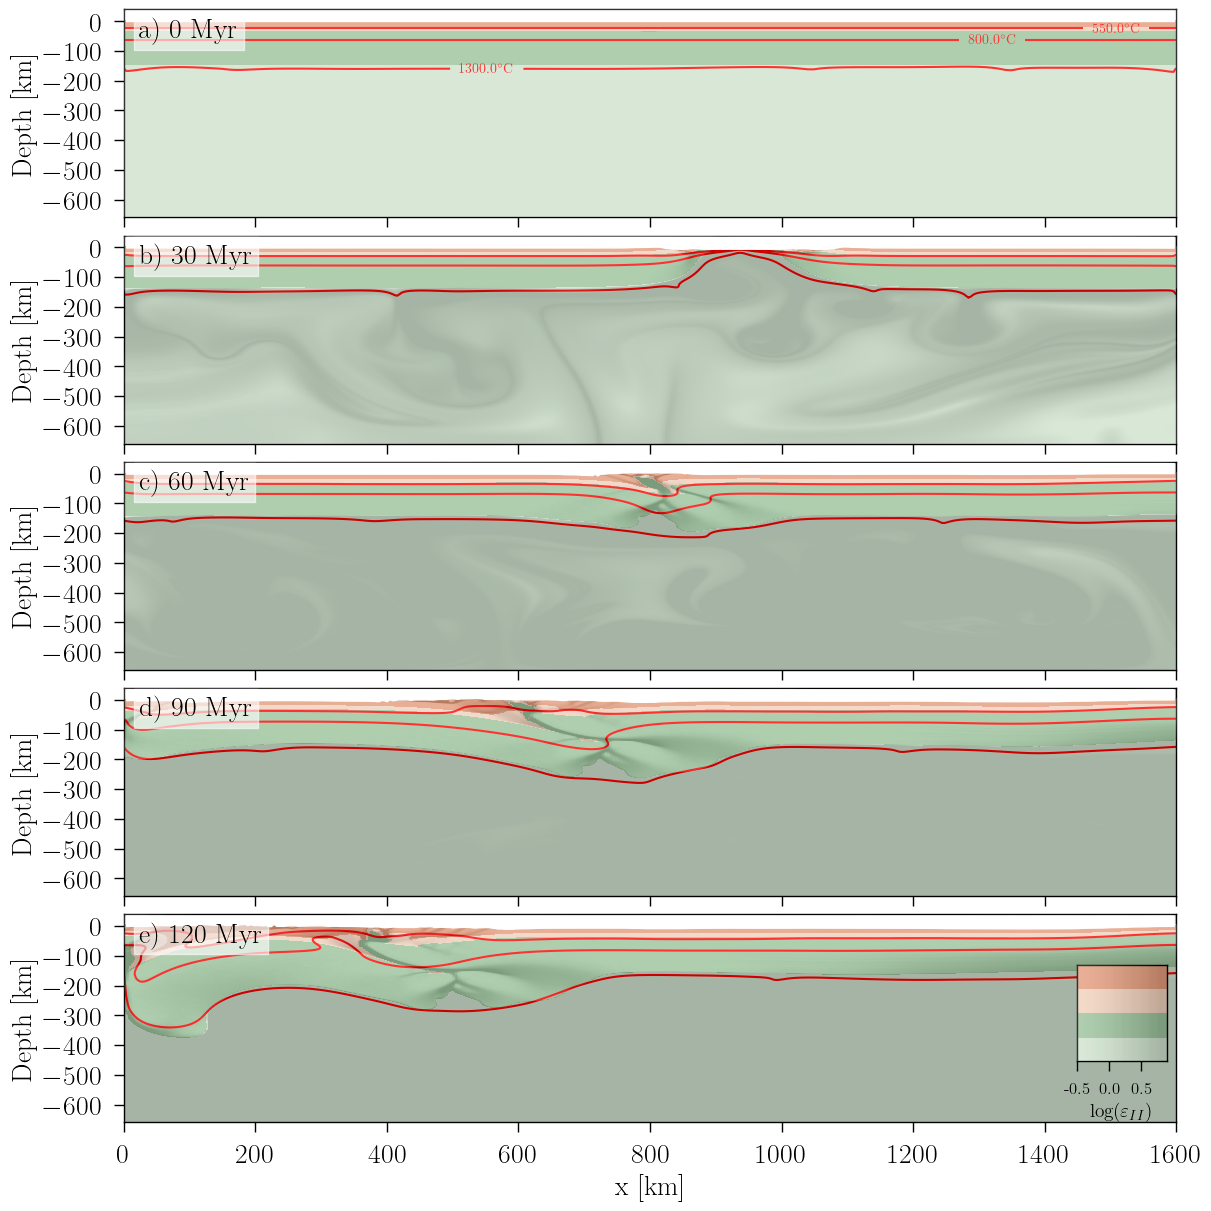

In [3]:
#Set scenario path

#STABLE NoHprodAst
# scenario = '/Doutorado/cenarios/mandyoc/stable/NoHprodAst/stable_PT0_rheol19_1Gyr_400ppe_10x10_c_1250_C1/'
# scenario = '/Doutorado/cenarios/mandyoc/stable/NoHprodAst/stable_PT100_rheol19_c1250_C1/'
# scenario = '/Doutorado/cenarios/mandyoc/stable/NoHprodAst/stable_PT200_rheol19_c1250_C1/'

###############################################################################################################################################################################

#STABLE With HprodAst lit80km
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst/'
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT290_rheol19_c1250_C1_HprodAst/'
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT350_rheol19_c1250_C1_HprodAst/'

###############################################################################################################################################################################

#STABLE With HprodAst lit150km
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/'
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT290_rheol19_c1250_C1_HprodAst_Hlit150km/'
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT350_rheol19_c1250_C1_HprodAst_Hlit150km/'

###############################################################################################################################################################################

#ACCORDION lit150km mean temperature for the lithosphere
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT200_PT1352oC/Sim001_rheol19_acc_DT200_PT1352oC_TBC_mean_lit150km/'
scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT200_PT1352oC/Sim002_rheol19_acc_DT200_PT1352oC_TBC_mean_lit150km/'

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT290_PT1420oC/Sim001_rheol19_acc_DT290_PT1420oC_TBC_mean_lit150km/'
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT290_PT1420oC/Sim002_rheol19_acc_DT290_PT1420oC_TBC_mean_lit150km/'

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT350_PT1460oC/Sim001_rheol19_acc_DT350_PT1460oC_TBC_mean_lit150km/'
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit150km/DT350_PT1460oC/Sim002_rheol19_acc_DT350_PT1460oC_TBC_mean_lit150km/'

###############################################################################################################################################################################

#ACCORDION lit80km no mean temperature for the lithosphere
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT200_PT1291oC/Sim001_rheol19_acc_DT200_PT1291oC_TBC_mean/'
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT200_PT1291oC/Sim002_rheol19_acc_DT200_PT1291oC_TBC_mean/'

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT290_PT1349oC/Sim001_rheol19_acc_DT290_PT1349oC_TBC_mean/'
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/DT290_PT1349oC/Sim002_rheol19_acc_DT290_PT1349oC_TBC_mean/'

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit80km/DT350_PT1397oC/Sim001_rheol19_acc_DT350_PT1397oC_TBC_mean_lit80km/'
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit80km/DT350_PT1397oC/Sim002_rheol19_acc_DT350_PT1397oC_TBC_mean_lit80km/'

# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit80km/DT400_PT1437oC/Sim001_rheol19_acc_DT400_PT1437oC_TBC_mean_lit80km/'
# scenario = '/Doutorado/cenarios/mandyoc/accordion/Acc_TBC_interp_mean/mean_temp_litho/lit80km/DT400_PT1437oC/Sim002_rheol19_acc_DT400_PT1437oC_TBC_mean_lit80km/'

###############################################################################################################################################################################

#ACCORDION lit150km heterogeneous
# scenario = '/Doutorado/cenarios/mandyoc/accordion/lit150km_hetero/DT200_PT1352oC/Sim001_acc_DT200_PT1352oC_mean_lit_hetero/'
# scenario = '/Doutorado/cenarios/mandyoc/accordion/lit150km_hetero/DT200_PT1352oC/Sim002_acc_DT200_PT1352oC_mean_lit_hetero/'

###############################################################################################################################################################################

#ACCORDION_KEEL
# scenario = '/Doutorado/cenarios/mandyoc/accordion_keel/Acc_TBC_interp_mean/DT200/mean_keel_center/Sim001_rheol19_acc_DT200_PT1232oC_TBC_mean_keel_center/'
# scenario = '/Doutorado/cenarios/mandyoc/accordion_keel/Acc_TBC_interp_mean/DT200/mean_keel_center/Sim002_rheol19_acc_DT200_PT1232oC_TBC_mean_keel_center/'

###############################################################################################################################################################################

#ACCORDION lit150km temper from mean keel center
# scenario = '/Doutorado/cenarios/mandyoc/accordion_keel/Acc_TBC_interp_mean/DT200/mean_keel_center/Sim002_rheol19_acc_DT200_PT1232oC_TBC_mean_keel_center/'

###############################################################################################################################################################################

#RIFTING lit80km
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1437oC/1x1km2/Clc1_DT350_PT1437oC_lit80km/'
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1437oC/1x1km2/Clc10_DT350_PT1437oC_lit80km/'

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1437oC/1x1km2/WHK/Clc1_DT350_PT1437oC_lit80km_1x1km2_WHK/'
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1437oC/1x1km2/WHK/Clc10_DT350_PT1437oC_lit80km_1x1km2_WHK/'

###############################################################################################################################################################################

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1437oC/2x2km2/Clc1_DT350_PT1437oC_lit80km/'
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1437oC/2x2km2/Clc10_DT350_PT1437oC_lit80km/'

###############################################################################################################################################################################

#RIFTING lit150km
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK/'
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK/'
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/WHK/Clc1_DT350_PT1460oC_lit150km_1x1km2_WHK/'
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/WHK/Clc10_DT350_PT1460oC_lit150km_1x1km2_WHK/'

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/2x2km2/Clc1_DT350_PT1460oC_lit150km/'
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/2x2km2/Clc10_DT350_PT1460oC_lit150km/'

###############################################################################################################################################################################

#BELLON, SILVA and SACEK
# scenario = '/Doutorado/cenarios/mandyoc/Bellon_and_Silva/Sim002/'
# scenario = '/Doutorado/cenarios/mandyoc/Bellon_and_Silva/Clc10_hlit180km/'
# scenario = '/Doutorado/cenarios/mandyoc/Bellon_and_Silva/sp/Clc10_hlit180km_sp_BSS/'
# scenario = '/Doutorado/cenarios/mandyoc/Bellon_and_Silva/sp/Clc1_hlit180km_sp_BSS/'

##############################################################################################################
#Creating path to the experiment

fpath = machine_path + scenario
print(fpath)

##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'topography'
# prop = 'viscosity'

##############################################################################################################
#Set instants
# instants = [0]
# instants = [1000]
# instants = [0, 100, 250, 500, 1000]
# instants = [0, 25, 50, 90, 150]
# instants = [0, 10, 20, 30, 40]
# instants = [0, 30, 60, 90, 130]
instants = [0, 30, 60, 90, 120] #Myr
# instants = [0, 30, 60, 90, 120, 150]

##############################################################################################################
#Reading scenario basic informations

times, steps = read_times_steps(fpath)
Nx, Nz, Lx, Lz = read_params(fpath)

##############################################################################################################
#Set domain limits of the figure

if(prop != 'topography'):
    xlims = [0, Lx / 1.0e3]
    ylims = [-Lz / 1.0e3 + 40, 40]
else:
    xmin = 0 #+ 200
    xmax = Lx / 1.0E3 #- 200
    xlims = [xmin, xmax]
    ylims = [-6, 6]

##############################################################################################################
#Creating figure and subplots

if(len(instants) > 1):
    fig_height = (3.0/2.0)*(len(instants) + 3) #6 minimum
#     fig_height = (2.0)*(len(instants) + 1) #4 is minimum

    fig, axs = plt.subplots(len(instants), 1, constrained_layout=True, figsize=(12, fig_height), sharex=True, sharey=True)
    axs = trim_axs(axs, len(instants))
else:
    fig, axs = plt.subplots(len(instants), 1, constrained_layout=True, figsize=(12,4), sharex=True, sharey=True)


alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(instants)]

##############################################################################################################
#Plot data

if(len(instants) > 1):
    for instant, ax in zip(instants, axs):
        idx = find_nearest(times, instant)
        step = steps[idx]
        plot_data(fpath, ax, axs, prop, instants, step, xlims, ylims)
        #print(steps[idx], times[idx], instant)
else:
    idx = find_nearest(times, instants[0])
    step = steps[idx]
    ax = axs
    plot_single_step(fpath, axs, prop, instants, step, xlims, ylims)
    
##############################################################################################################
#Setting plot details

if(len(instants) > 1):
    axs[0].set_xlim(xlims)
    axs[0].set_ylim(ylims)

    fsize = 20
    axs[-1].set_xlabel('x [km]', fontsize=fsize)
    for ax, letter, instant in zip(axs, letters, instants):
        label_text = letter + ') ' + str(instant) + ' Myr'
        ax.text(0.015,
                0.90,
                label_text,
                color='k',
                bbox=dict(edgecolor = 'white',
                          facecolor = 'white',
                          alpha = 0.6),
                fontsize=fsize,
                horizontalalignment='left',
                verticalalignment='center',
                transform=ax.transAxes,
                zorder=52)

        if(prop != 'topography'):
            ax.set_ylabel('Depth [km]', fontsize=fsize)
            ax.tick_params(axis='both', labelsize=fsize)
            axs[-1].tick_params(axis='both', labelsize=fsize)
#             ax.set_yticks(np.linspace(ylims[0], 0, 5))
            ax.set_yticks(np.arange(0, ylims[0], -100))
#             ax.set_yticks(np.linspace(ylims[0]+60, 0, 7))
        else:
            ax.set_ylabel('Topography [km]', fontsize=fsize)
            ax.tick_params(axis='both', labelsize=fsize)
            axs[-1].tick_params(axis='both', labelsize=fsize)
            nticks = np.abs(ylims[1] - ylims[0] + 1)
            ax.set_yticks(np.linspace(ylims[0], ylims[1], nticks))
            ax.grid('-k', alpha = 0.7)
else:
    axs.set_xlim(xlims)
    axs.set_ylim(ylims)

    fsize = 20
    axs.set_xlabel('x [km]', fontsize=fsize)
    
    label_text = str(instants[0]) + ' Myr'
    axs.text(0.015,
            0.92,
            label_text,
            color='k',
            bbox=dict(edgecolor = 'white',
                      facecolor = 'white',
                      alpha = 0.6),
            fontsize=fsize,
            horizontalalignment='left',
            verticalalignment='center',
            transform=axs.transAxes,
            zorder=52)

    if(prop != 'topography'):
        axs.set_ylabel('Depth [km]', fontsize=fsize)
        axs.tick_params(axis='both', labelsize=fsize)
        axs.tick_params(axis='both', labelsize=fsize)
#         ax.set_yticks(np.linspace(ylims[0], 0, 5))
        axs.set_yticks(np.linspace(ylims[0]+60, 0, 7))
    else:
        axs.set_ylabel('Topography [km]', fontsize=fsize)
        axs.tick_params(axis='both', labelsize=fsize)
        axs[-1].tick_params(axis='both', labelsize=fsize)
        nticks = np.abs(ylims[1] - ylims[0] + 1)
        axs.set_yticks(np.linspace(ylims[0], ylims[1], nticks))
        axs.grid('-k', alpha = 0.7)
    
##############################################################################################################
#Saving figure

if(len(instants) > 1):
    figname = scenario.split('/')[-2] + '_' + prop
else:
    figname = scenario.split('/')[-2] + '_' + prop + '_single_step'
    
print(figname)

#This will save inside the notebook directory
fig.savefig('out/plots/' + figname+'.pdf', dpi=400)
fig.savefig('out/plots/' + figname+'.png', dpi=400)

#This will save inside the experiment directory
fig.savefig(fpath+figname+'.pdf', dpi=400)
fig.savefig(fpath+figname+'.png', dpi=400)